# Projet Data Science - Choix des modèles de machine learning
### Enzo Risbetz et Charles-Meldhine MADI MNEMOI


Pour comprendre et évaluer les modèles, nous allons considérer les algorithmes ML suivants :

1er choix - Régression linéaire

L'analyse de régression linéaire sert à prévoir la valeur d'une variable en fonction de la valeur d'une autre variable. Elle est utilisée pour trouver une relation linéaire entre la cible et un ou plusieurs prédicteur(s). L'idée principale est d'identifier une ligne qui s'adapte le mieux aux données. La ligne la mieux ajustée est celle pour laquelle l'erreur de prédiction est la plus faible.

2ème choix - Régression lasso / ridge

La régression lasso / ridge rajoute une pénalité au coefficient de la régression linéaire. Le coef permet de réguler la variable expliqué entre les données d'entraienement et les données de test.

3ème choix - Arbre de décision

Un arbre de décision est un outil d'aide à la décision représentant un ensemble de choix sous la forme graphique d'un arbre. Les différentes décisions possibles sont situées aux extrémités des branches (les « feuilles » de l'arbre), et sont atteintes en fonction de décisions prises à chaque étape.

4ème choix - Random forest

Le random forest est composé de plusieurs arbres de décision, travaillant de manière indépendante sur une vision d'un problème. Chacun produit une estimation, et c'est l'assemblage des arbres de décision et de leurs analyses, qui va donner une estimation globale.

Le random forest est un modèle d'apprentissage, dont l'efficacité dépend fortement de la qualité de l'échantillon de données de départ.

Random Forest est bien plus flexible qu'un modèle de régression linéaire.

### Import des packages et des données


In [1]:
from copy import copy
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px

#librarie permettant d'utiliser la version Intel de Scikit-learn pour certaines fonctions, 10 à 100 fois plus rapide
from sklearnex import patch_sklearn, unpatch_sklearn

sns.set()
np.random.seed(0)


In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/cmnemoi/ProjetDataScienceLPSID/main/data/explored_dataset.csv")

In [ ]:
dataset.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel,day,hour,is_night_trip,airport_trip
0,1.0,2020-05-01 00:23:21,2020-05-01 00:26:01,2.0,0.4,1.0,N,264,264,1.0,5.80,NV,NV,1,0,1,0
1,1.0,2020-05-01 00:54:58,2020-05-01 00:57:11,1.0,0.3,1.0,N,264,264,2.0,4.80,NV,NV,1,0,1,0
2,1.0,2020-05-01 00:07:10,2020-05-01 00:12:46,1.0,1.7,1.0,N,107,229,2.0,10.80,Gramercy,Sutton Place/Turtle Bay North,1,0,1,0
3,1.0,2020-05-01 00:09:46,2020-05-01 00:27:44,1.0,2.9,1.0,N,79,237,2.0,15.80,East Village,Upper East Side South,1,0,1,0
4,1.0,2020-05-01 00:22:48,2020-05-01 00:28:58,1.0,1.5,1.0,N,140,263,1.0,12.95,Lenox Hill East,Yorkville West,1,0,1,0


In [3]:
X = dataset.drop(["tpep_pickup_datetime", "tpep_dropoff_datetime", "RatecodeID", "PULocationLabel", "DOLocationLabel", "total_amount"], axis=1)
y = dataset[["total_amount"]]

### Codage des variables

In [4]:
X["VendorID"] = X["VendorID"].astype(int).astype("category")
X["passenger_count"] = X["passenger_count"].astype(int)
X["store_and_fwd_flag"] = X["VendorID"].astype("category")
X["PULocationID"] = X["PULocationID"].astype(int).astype("category")
X["DOLocationID"] = X["DOLocationID"].astype(int).astype("category")
X["payment_type"] = X["payment_type"].astype(int).astype("category")
X["day"] = X["day"].astype(int).astype("category")
X["hour"] = X["hour"].astype(int).astype("category")
X["is_night_trip"] = X["is_night_trip"].astype(int).astype("category")
X["airport_trip"] = X["airport_trip"].astype(int).astype("category")

### Train test split

Nous allons maintenant partager notre dataset en un jeu de données d'entraînement, jeu de données de validation et jeu de données de test.

Le jeu d'entraînement est utilisé pour entraîner notre modèle.
 
Le jeu de validation est utilisé pour évaluer le modèle sur des données qu'il ne connaît pas, optimiser les hyperparamètres et comparer les modèles entre eux afin de choisir le plus performant.
 
Le jeu de test est utilssé pour évaluer notre modèle final et s'assurer qu'il a bien appris quelque chose de pertinent. 
 
(Il ne faut jamais utiliser le jeu de test pour comparer des modèles)
 
Il est nécessaire de faire ainsi afin d'éviter que nos modèles ne soient trop ajustés aux données (overfitting) et se généralise aux nouvelles données.

On alloue 70% des données au jeu d'entraînement et 30% au jeu de test (proportion recommandée par la littérature scientifique) :

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train.columns = ["total_amount"]
y_test.columns = ["total_amount"]

In [7]:
print(X_train.size, X_test.size)

2075876 889669


On utilisera la technique de la validation croisée pour créer un jeu de données de validation durant la phase de modélisation.

### Préprocessing

Dans le notebook de nettoyage de données, nous avons exhibé des colonnes (`trip_distance` et `total_amount`) méritant du preprocessing :    


*   Seuil pour les valeurs extrêmes
*   Transformations non linéaires (logarithmes)...

On doit également standardiser toutes les variables pour respecter les hypothèses de certains algorithmes comme la régression linéaire.

On créé donc plusieurs sous-datasets afin d'observer l'effet de ces transformations sur la performance de nos modèles.


#### Remplacement des valeurs extrêmes par un seuil (trimming)




On remplace les valeurs supérieures au 99e centile par le 99e centile :

In [6]:
quantile = X_train["trip_distance"].quantile(q=.99)
trimmed_X_train = X_train.copy()
trimmed_X_train["trip_distance"] = [quantile if x > quantile else x for x in X_train["trip_distance"]]

trimmed_X_test = X_test.copy()
trimmed_X_test["trip_distance"] = [quantile if x > quantile else x for x in X_test["trip_distance"]]


In [7]:
quantile = y_train["total_amount"].quantile(q=.99)
trimmed_y_train = y_train.copy()
trimmed_y_train["total_amount"] = [quantile if y > quantile else y for y in y_train["total_amount"]]

trimmed_y_test = y_test.copy()
trimmed_y_test["total_amount"] = [quantile if y > quantile else y for y in y_test["total_amount"]]

#### Transformation non linéaire (logarithmique)


On transforme `trip_distance` et `total_amount` par leur logarithme pour obtenir une distance plus proche de la loi normale :

In [8]:
log_X_train = X_train.copy()
log_X_train["trip_distance"] = np.log(X_train["trip_distance"])

log_X_test = X_test.copy()
log_X_test["trip_distance"] = np.log(X_test["trip_distance"])

In [9]:
log_y_train = y_train.copy()
log_y_train["total_amount"] = np.log(y_train["total_amount"])

log_y_test = y_test.copy()
log_y_test["total_amount"] = np.log(y_test["total_amount"])

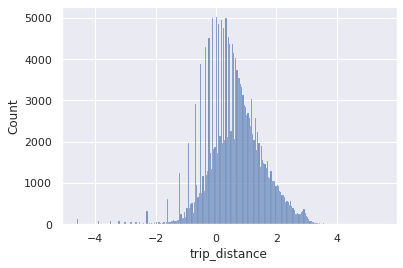

In [12]:
sns.histplot(x=log_X_train["trip_distance"])

#### Standardisation
On remplace les variables qualitatives X par : $\frac{X - \mu }{\sigma}$ avec $\mu$ la moyenne de la variable et $\sigma$ son écart-type :

In [10]:
from sklearn.preprocessing import StandardScaler

standardized_X_train = X_train.copy()
standardized_X_train["trip_distance"] = StandardScaler().fit_transform(X_train[["trip_distance"]])

standardized_X_test = X_test.copy()
standardized_X_test["trip_distance"] = (X_test["trip_distance"] - X_train["trip_distance"].mean()) / X_train["trip_distance"].std()

Note : on utilisera par la suite des objets `Pipeline` pour simplifier le code et éviter encore plus le [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/).

### Modélisation

On peut enfin passer à la modélisation. 

Le machine learning consiste à trouver une fonction de prédiction f telle que y = f(X).
Pour estimer f, on cherche à minimiser la fonction coût C.

Ayant à faire à un problème de régression, on a le choix, entre autres, les fonctions coût suivantes :     


*   Mean Squared Error : $MSE = \frac{1}{n} \sum_{i=1}^{n}(y-f(x_{i}))^{2}$
*   Root Mean Squared Error : $RMSE = \frac{1}{n} \sum_{i=1}^{n}\sqrt{(y-f(x_{i}))^{2}}$
*   Mean Absolute Error : $MAE = \frac{1}{n} \sum_{i=1}^{n}\left|{y-f(x_{i})}\right|$

Pour notre étude, on choisit les fonctions coût `Mean Squared Error` (MSE) et `Mean Aboslute Error` (MAE).
On notera que la MAE est moins sensible aux valeurs extrêmes que la MSE, et est de la même unité que la variable cible.


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = 'neg_mean_absolute_error'
MSE = 'neg_mean_squared_error'

#### Validation croisée

Revenons sur la validation croisée, spécifiquement la version *K-folds*.
 
Elle consiste à séparer le jeu de données d'entraînement en K sous-ensembles. On entraîne alors le modèle à l'aide des K-1 premiers sous-ensembles et on teste (=valide) ces performances sur le K-ième.

On échange ensuite les rôles jusqu'à ce que chaque sous ensemble ait servi de jeu de validation.


<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="400" height="277" />

On peut ainsi vérifier que le modèle n'est pas sur-ajusté par rapport aux données d'entraînement en traçant les courbes d'apprentissage :

<img src="https://1.cms.s81c.com/sites/default/files/2021-03-03/classic%20overfitting_0.jpg" width="400" height="377" />

La fonction suivante fait exactement cela : appliquer une validation croisée et tracer les courbes d'apprentissage :

In [12]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator,
    X,
    y,
    title="Learning curves",
    score='neg_mean_absolute_error',
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 50),
):
    """
    Generate  the val and training learning curve
    Source : https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.
    
    score: scoring object

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, val) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(7, 7))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, val_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=score
    )
    train_scores_mean = abs(np.mean(train_scores, axis=1))
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = abs(np.mean(val_scores, axis=1))
    val_scores_std = np.std(val_scores, axis=1)
    fit_times_mean = abs(np.mean(fit_times, axis=1))
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, val_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    score_to_print = score.split("_",1)[-1]

    print(f"Training {score_to_print} : {train_scores_mean.mean():.3f} (+/- {train_scores_std.mean():.3f})")
    print(f"Validation {score_to_print} : {val_scores_mean.mean():.3f} (+/- {val_scores_std.mean():.3f})")

    return plt


#### GridSearchCV

In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from ray.tune.sklearn import TuneGridSearchCV


#### Régression linéaire

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

##### Vanilla

Training mean_absolute_error : 1.745 (+/- 0.011)
Validation mean_absolute_error : 1.737 (+/- 0.019)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

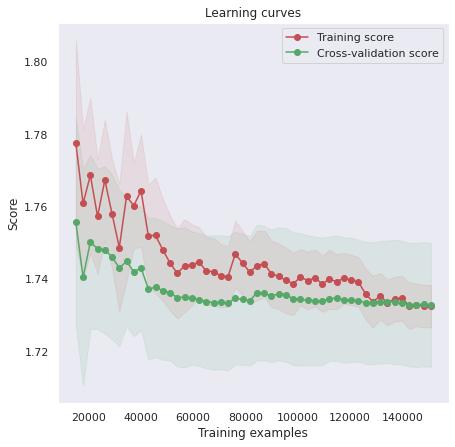

In [18]:
plot_learning_curve(LinearRegression(n_jobs=-1), X_train, y_train, score=MAE)

Training mean_squared_error : 20.279 (+/- 1.900)
Validation mean_squared_error : 18.297 (+/- 4.306)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

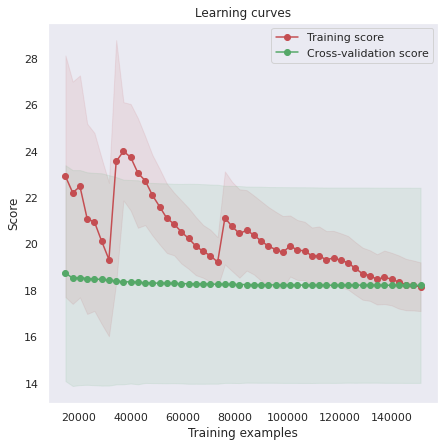

In [19]:
plot_learning_curve(LinearRegression(n_jobs=-1), X_train, y_train, score=MSE)

##### Standardised dataset

In [ ]:
standardized_linear_regression = Pipeline([('Z-score_scaler', StandardScaler()), ('linear_regression', LinearRegression(n_jobs=-1))])

Training mean_absolute_error : 1.745 (+/- 0.011)
Validation mean_absolute_error : 1.737 (+/- 0.019)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

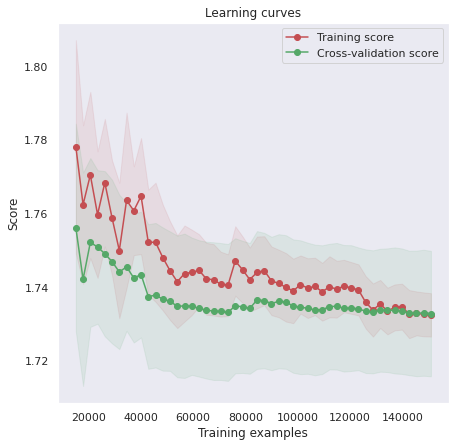

In [ ]:
plot_learning_curve(standardized_linear_regression, X_train, y_train, score=MAE)

Training mean_squared_error : 20.281 (+/- 1.901)
Validation mean_squared_error : 18.299 (+/- 4.305)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

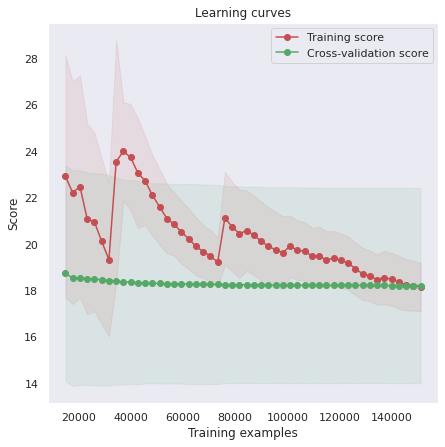

In [ ]:
plot_learning_curve(standardized_linear_regression, X_train, y_train, score=MSE)

##### Trimmed dataset

Training mean_absolute_error : 1.584 (+/- 0.004)
Validation mean_absolute_error : 1.582 (+/- 0.009)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

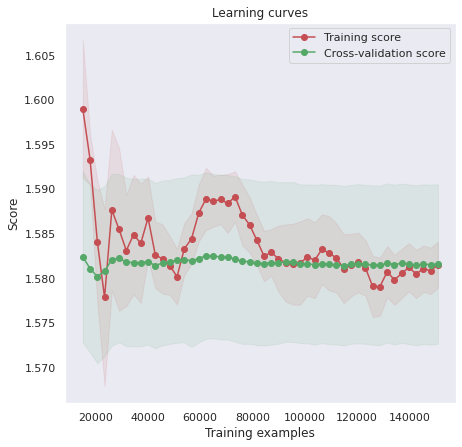

In [ ]:
plot_learning_curve(LinearRegression(n_jobs=-1), trimmed_X_train, trimmed_y_train, score=MAE)

Training mean_squared_error : 8.878 (+/- 0.109)
Validation mean_squared_error : 8.768 (+/- 0.319)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

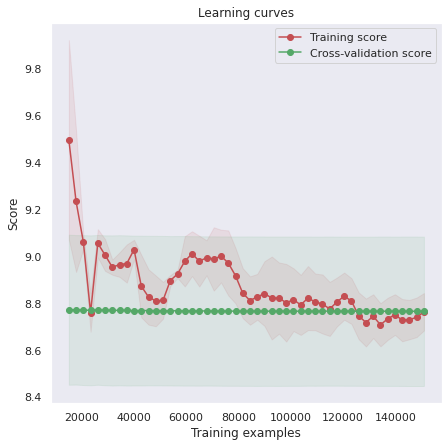

In [ ]:
plot_learning_curve(LinearRegression(n_jobs=-1), trimmed_X_train, trimmed_y_train, score=MSE)

##### Trimmed dataset + Standardization

Training mean_absolute_error : 1.583 (+/- 0.004)
Validation mean_absolute_error : 1.581 (+/- 0.009)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

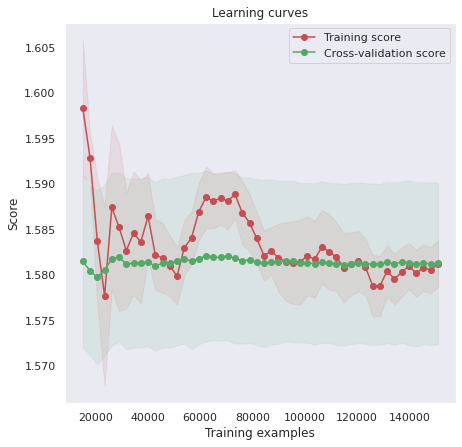

In [ ]:
plot_learning_curve(standardized_linear_regression, trimmed_X_train, trimmed_y_train, score=MAE)

Training mean_squared_error : 8.880 (+/- 0.109)
Validation mean_squared_error : 8.769 (+/- 0.319)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

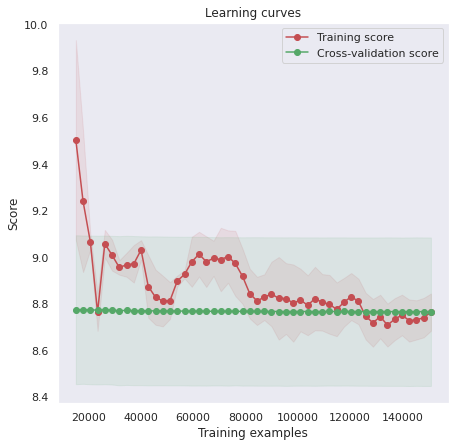

In [ ]:
plot_learning_curve(standardized_linear_regression, trimmed_X_train, trimmed_y_train, score=MSE)

#### Régression Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

vanilla_elastic_net = ElasticNet(random_state=0)

Training mean_absolute_error : 2.050 (+/- 0.006)
Validation mean_absolute_error : 2.044 (+/- 0.021)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

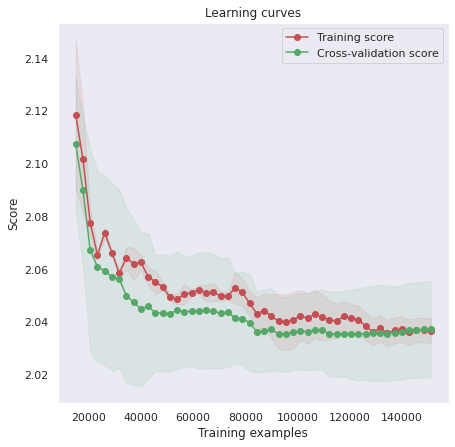

In [ ]:
plot_learning_curve(vanilla_elastic_net, X_train, y_train, score=MAE)

Training mean_squared_error : 21.965 (+/- 1.873)
Validation mean_squared_error : 20.006 (+/- 4.494)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

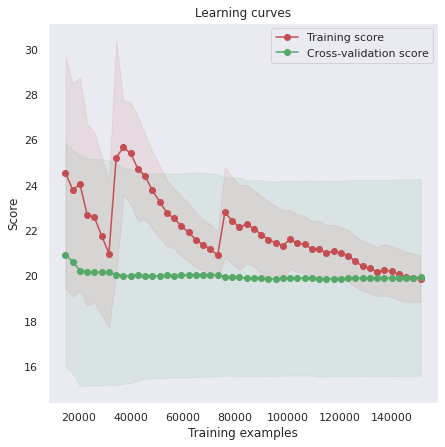

In [ ]:
plot_learning_curve(vanilla_elastic_net, X_train, y_train, score=MSE)

#### Arbre de décision

In [57]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

##### Vanilla

In [58]:
vanilla_tree = DecisionTreeRegressor(criterion="absolute_error", random_state=0)


https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

Training mean_absolute_error : 0.003 (+/- 0.001)
Validation mean_absolute_error : 10.346 (+/- 0.152)
CPU times: user 736 ms, sys: 54.2 ms, total: 790 ms
Wall time: 1min 59s


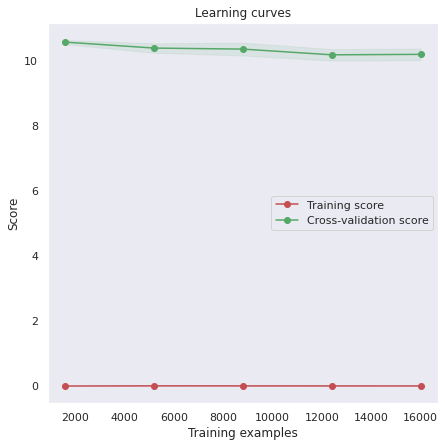

In [74]:
plot_learning_curve(vanilla_tree, X_train.sample(20000), y_train.sample(20000), score=MAE, train_sizes=np.linspace(0.1,1,5))

##### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

vanilla_tree = DecisionTreeRegressor(criterion="absolute_error", random_state=0)

parameters = {"max_leaf_nodes": [2]}
CV_tree = GridSearchCV(vanilla_tree, parameters, n_jobs=-1, cv=3)

In [ ]:
CV_tree.fit(X_train.sample(20000), y_train.sample(20000)).best_estimator_

DecisionTreeRegressor(criterion='absolute_error', max_leaf_nodes=2,
                      random_state=0)

In [ ]:
parameters = {"max_leaf_nodes": [2], "max_depth": np.arange(1,5,1)}
CV_tree = GridSearchCV(vanilla_tree, parameters, n_jobs=-1, cv=3)

In [ ]:
CV_tree.fit(X_train.sample(20000), y_train.sample(20000)).best_estimator_

DecisionTreeRegressor(criterion='absolute_error', max_depth=1, max_leaf_nodes=2,
                      random_state=0)

Training mean_absolute_error : 6.277 (+/- 0.055)
Validation mean_absolute_error : 6.249 (+/- 0.118)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

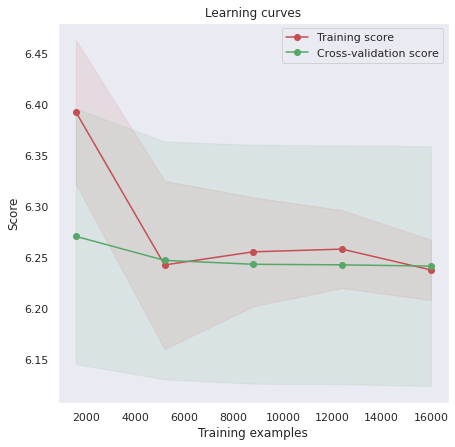

In [ ]:
CV_tree = DecisionTreeRegressor(criterion='absolute_error', max_depth=1, max_leaf_nodes=2,
                      random_state=0)
plot_learning_curve(CV_tree, X_train.sample(20000), y_train.sample(20000), score=MAE, train_sizes=np.linspace(0.1, 1, 5))

#### Random forest

In [14]:
patch_sklearn("RandomForestRegressor")
from sklearn.ensemble import RandomForestRegressor

vanilla_rf = RandomForestRegressor(n_estimators=100, criterion="absolute_error", random_state=0)
parameters = {"max_depth": np.arange(3,12,1)}

vanilla_rf = GridSearchCV(vanilla_rf, parameters, n_jobs=-1, cv=3)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
vanilla_rf.fit(X_train.sample(5000), y_train.sample(5000)).best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestRegressor(criterion='absolute_error', max_depth=11, random_state=0)

In [ ]:
from ray.tune.sklearn import TuneGridSearchCV

vanilla_rf = RandomForestRegressor(n_estimators=100, max_depth=11, criterion="absolute_error", random_state=0)
parameters = {"max_leaf_nodes": np.arange(2**11-1000, 2**11, 100)}

vanilla_rf = TuneGridSearchCV(vanilla_rf, parameters, scoring=MAE, n_jobs=-1, cv=3, use_gpu=True)

In [ ]:
vanilla_rf.fit(X_train.sample(5000), y_train.sample(5000)).best_estimator_

2022-05-20 14:25:55,092	INFO trial_runner.py:803 -- starting _Trainable_c1bb6_00000
(_Trainable pid=1334) /usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=1334)   estimator.fit(X_train, y_train, **fit_params)
(_Trainable pid=1334) /usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=1334)   estimator.fit(X_train, y_train, **fit_params)
(_Trainable pid=1334) /usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel

RandomForestRegressor(criterion='absolute_error', max_depth=11,
                      max_leaf_nodes=1048, random_state=0)

In [ ]:
vanilla_rf = RandomForestRegressor(n_estimators=100, max_depth=11, criterion="absolute_error", random_state=0)
parameters = {"max_leaf_nodes": np.arange(20, 1048, 100)}

vanilla_rf = TuneGridSearchCV(vanilla_rf, parameters, scoring=MAE, n_jobs=-1, cv=3, use_gpu=True)

In [ ]:
vanilla_rf.fit(X_train.sample(5000), y_train.sample(5000)).best_estimator_

2022-05-20 14:42:12,421	INFO trial_runner.py:803 -- starting _Trainable_08c14_00000
(_Trainable pid=1659) /usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=1659)   estimator.fit(X_train, y_train, **fit_params)
(_Trainable pid=1659) /usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
(_Trainable pid=1659)   estimator.fit(X_train, y_train, **fit_params)
(_Trainable pid=1659) /usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel

RandomForestRegressor(criterion='absolute_error', max_depth=11,
                      max_leaf_nodes=20, random_state=0)